# EDA 📊 - Exploring the VisualGo Dataset

In [7]:
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import numpy as np

from PIL import Image

import cv2

import os

from skimage.transform import resize
from skimage.draw import polygon2mask, polygon, polygon_perimeter

import torch
import torchvision.transforms as T

import seaborn as sns

from tqdm import tqdm, tqdm_notebook

with open("result.json") as json_file:
    jsonData = json.load(json_file)

## Table of Contents 📋
1. [Quick introduction 🚀](#Quick-introduction-🚀)
2. [How was this dataset generated? ⚗️](#How-was-this-dataset-generated?-⚗️)
3. [The dataset 📈](#The-dataset-📈)
    - [Camera position 📷](#Camera-position-📷)
    - [Pixel Heatmap 🗺️](#Pixel-Heatmap-🗺️)
    - [Material randomization 🏗️](#Material-randomization-🏗️)
4. [A simple parser class with PyTorch dataloader support ⚙️](#A-simple-parser-class-with-PyTorch-dataloader-support-⚙️)
5. [What now?](#What-now?)

## Quick introduction 🚀

The dataset consists of **over a thousand** of **rendered images** with the size (800 x 800), **polygon masks** defined by four or more coordinates and a **csv files** resembeling the current board states.

The dataset was created with the model architecture I developed in mind, hence the goal is to predict the position of the board and use a perspective warped version of the original image for the state prediction.

## How was this dataset generated? ⚗️
The VisualGo dataset was created for a project of mine. I recently got into the <a href="https://en.wikipedia.org/wiki/Go_(game)">game of Go</a> after watching the amazing <a href="https://www.alphagomovie.com/">AlphaGo movie</a> and wanted to try to extract the current go state from an image. Since I didn't have the resources neither the time to create an approriate amount of data (creating random board states by hand takes a hell of a time 🙃), I fired up Blender and YouTube to learn how to render photorealistic go boards.

<img src="assets/blenderScript.png">

This left me with these amazing renders, which all use different camera perspectives, lighting and board states. I am actually quite happy with them 😀.

<img src="assets/header1.png">

Rendering these saved me a lot of time and I was hoping that the renders would be close enough to real photos to actual work with them. This is where I realized, that I messed up. How should I predict the board state, without even finding the board itself using image segmentation, hence needing a ground truth mask. This could have been easily done by applying white and black materials to the scene... 

Well, maybe next time.

So I went out to label all thousand images by hand using this amazing opensource tool called <a href="https://labelstud.io/">LabelStudio</a>.

<img src="assets/labelstudio.png">

This left me with the dataset I used in this project, which we are going to explore in this notebook to get a better understanding of it.

## The dataset 📈

### Camera position 📷

TODO

### Pixel Heatmap 🗺️
Since the camera position is randomized, we have all sorts of angles and image positions we have to deal with. This heatmap shows, how many times a pixel is present in every mask.

[]

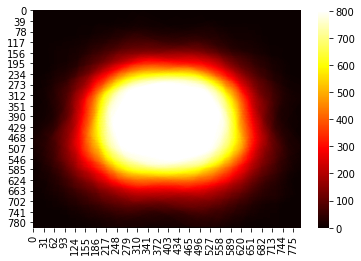

In [68]:
d = MaskDataset("result.json","board_masks/upload/", 800)
hm = d[0][1]
for i in range(1, len(d)):
    hm += d[i][1]
sns.heatmap(hm, cmap="hot")
plt.plot()

As you can see, the board is mostly in the center of the image, which is a desired behaviour. I think it just natural to have the board in the center of an image, if you intend to photograph it.

### Material randomization 🏗️

## A simple parser class with PyTorch dataloader support ⚙️
The following class is a dataloader-compatible parser for the VisualGo Dataset. It loads the images in to memory and creates a ground truth mask with the given polygon coordinates.

The whole dataset is stored in a single json file, which contains the polygon coordinates and the path to the image. 

A single datapoint looks like this:
```json
{'completions': [{'created_at': 1613317720,
   'id': 644001,
   'lead_time': 11.562,
   'result': [{'from_name': 'label',
     'id': 'jMpowm9ISJ',
     'image_rotation': 0,
     'original_height': 800,
     'original_width': 800,
     'to_name': 'image',
     'type': 'polygonlabels',
     'value': {'points': [[68, 14.666666666666666],
       [87.73333333333333, 68.93333333333334],
       [30.133333333333333, 88.13333333333334],
       [13.866666666666667, 31.6]],
      'polygonlabels': ['Board']}}]}],
 'data': {'image': '/data/upload/5020cb-board_643.jpg'},
 'id': 644}
```
Where the ```data``` key gives us the image path and the ```completions``` key the polygon coordinates. Since we are basically performing a two class segmentation (board or no board), we can just ignore the ```polygonlabels``` key.

The mask is created using the ```polygon2mask``` function from ```skimage```. It takes $n$ coordinates and returns a bool-array with the mask:

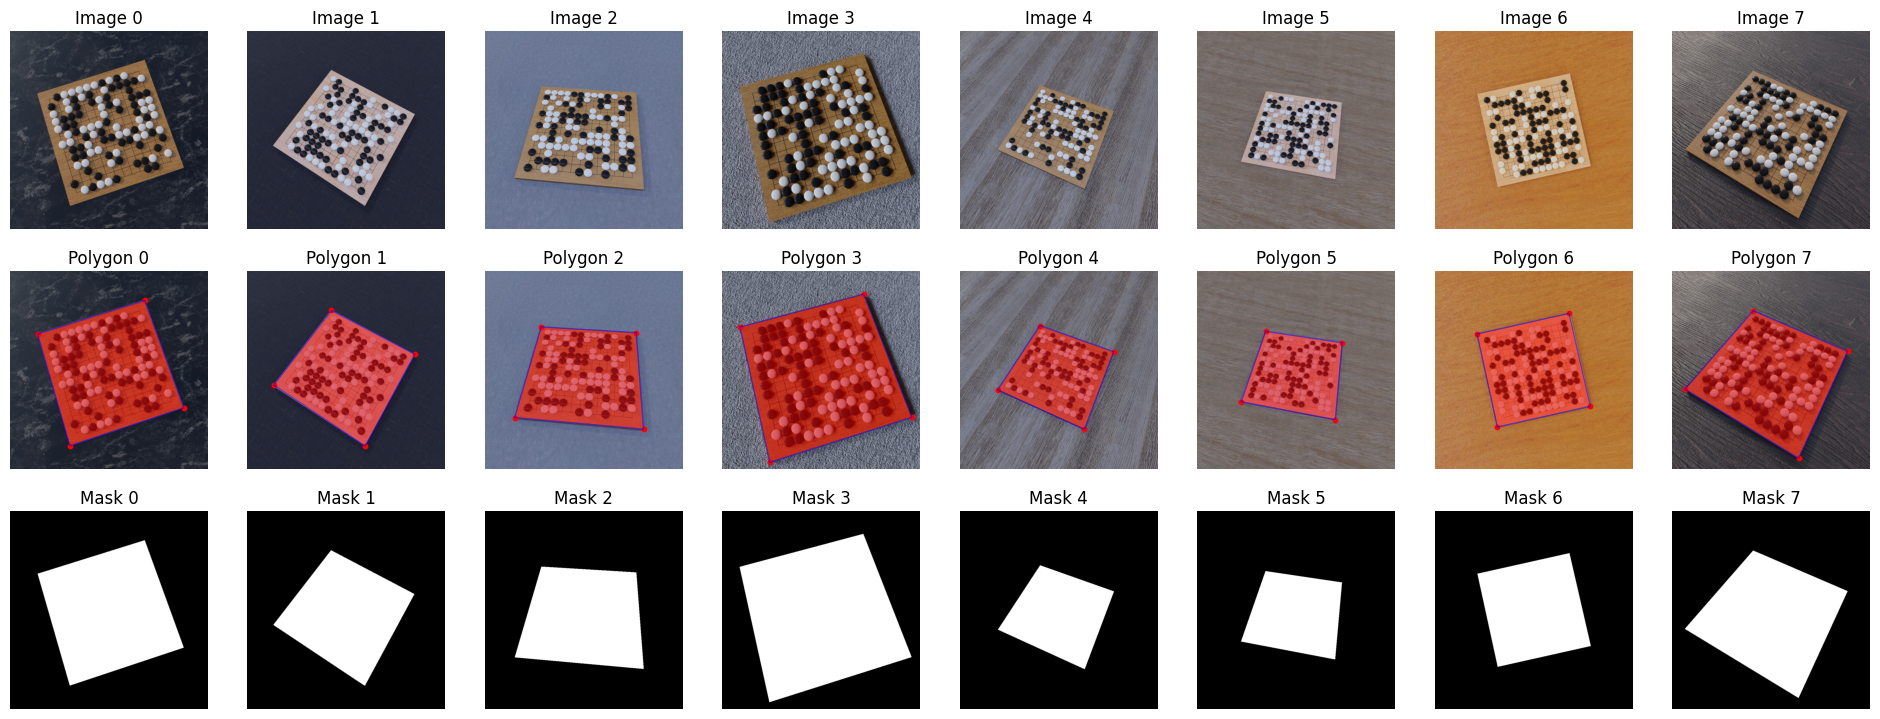

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(3,8, figsize=(24,9), dpi=100)

for i in range(8):

    p = jsonData[i]

    img = np.array(Image.open("board_masks/upload/" + os.path.basename(p["data"]["image"])))

    y = np.array(p["completions"][0]["result"][0]["value"]["points"])
    mask = polygon2mask((800,800), y*8).astype(bool).T
    
    # just the image
    ax1[i].imshow(img)
    ax1[i].title.set_text(f'Image {i}')
    
    # polygon
    ax2[i].imshow(img)
    p = Polygon((y*8), facecolor = 'r', alpha=0.5, edgecolor = "b")
    ax2[i].add_patch(p)
    ax2[i].scatter((y*8)[:,0], (y*8)[:,1], c="r", s=10)
    ax2[i].title.set_text(f'Polygon {i}')
    
    # gt mask
    ax3[i].imshow(mask, cmap="gray")
    ax3[i].title.set_text(f'Mask {i}')
    
    ax1[i].axis('off')
    ax2[i].axis('off')
    ax3[i].axis('off')

plt.show()

The following class does exactly that. It resizes the images, creates the mask and pluggs it all into tensors for training.

In [66]:
# define a dataset class for the Dataloaders
class MaskDataset:
    def __init__(self, baseFile , folder, image_size):
        self.basePath = folder
        self.imageSize = image_size
        
        # load the dataset
        with open(baseFile) as json_file:
            self.jsonData = json.load(json_file)
        
        self.images = []
        
        self.masks = []
        
        # save every image and ground truth mask
        for p in self.jsonData:
            data = p["data"]
            imagePath = data["image"]
        
            self.images.append(np.array(Image.open(self.basePath + os.path.basename(imagePath))))
            
            y = np.array(p["completions"][0]["result"][0]["value"]["points"])
            mask = polygon2mask((800,800), y*8).astype(bool).T
            
            self.masks.append(mask)
    
    def __len__(self):
        return len(self.jsonData)
    
    def __getitem__(self, index):
        
        # a simple image transformer wich resizes the images
        transform = T.Compose([
            T.ToPILImage(),
            T.Resize(self.imageSize),
            T.ToTensor(),
        ])
        
        img = self.images[index]
        X = transform(img)
        
        # resize the mask 
        mask = resize(self.masks[index], (self.imageSize,self.imageSize), order = 0, preserve_range=True)
        
        return X, torch.LongTensor(mask)
    